In [1]:
%load_ext line_profiler

In [5]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sys
import time
import pickle

from collections import Counter, defaultdict, OrderedDict, namedtuple
import random
import copy
import bisect
import heapq

import multiprocessing as mp
from multiprocessing import Pool

In [2]:
import warnings
warnings.filterwarnings('error')

In [6]:
with open('save/lifespans','rb') as f:
    lifespans = pickle.load(f)
with open('save/plt_agl_est','rb') as f:
    plt_agl_est = pickle.load(f)
with open('save/plt_ag', 'rb') as f:
    plt_ag = pickle.load(f)
with open('save/plt_agl', 'rb') as f:
    plt_agl = pickle.load(f)
with open('save/plt_ucb', 'rb') as f:
    plt_ucb = pickle.load(f)
with open('save/plt_ucbl_est', 'rb') as f:
    plt_ucbl_est = pickle.load(f)

In [5]:
records = pd.concat([pd.read_csv('data/ydata-fp-td-clicks-v2_0.'+ str(20111000+i), 
                                 sep=' ',
                                 names=['timestamp','id','clicked'],
                                 usecols=[0,1,2],) for i in range(2,17)])

In [8]:
lifespans = {}
for i in range(2,17):
    with open('data/ydata-fp-td-clicks-v2_0.'+ str(20111000+i)) as f:
        for line in f.readlines():
            timestamp = int(line[:10])
            components = line.strip().split(' |')
            for article in components[2:]:
                if article in lifespans:
                    lifespans[article][1] = timestamp
                else:
                    lifespans[article] = [timestamp, timestamp]

In [9]:
records.head()

,timestamp,id,clicked
0,1317513291,id-560620,0
1,1317513291,id-565648,0
2,1317513291,id-563115,0
3,1317513292,id-552077,0
4,1317513292,id-564335,0


In [10]:
len(records)

27777695

In [19]:
records.clicked.value_counts()

0    26749863
1     1027832
Name: clicked, dtype: int64

In [24]:
len(records.id.value_counts()), len(lifespans)

(652, 652)

In [10]:
with open('save/records','wb') as f:
    pickle.dump(records, f)

In [9]:
with open('save/lifespans', 'wb') as f:
    pickle.dump(lifespans, f)

In [5]:
class Arm:
    def __init__(self,lifespan):
        self.birth, self.death = lifespan
        self.s = None
        self.l = None
        self.T = 0
        self.rewards = 0
        self.X = -1
    def __repr__(self):
        return '{:.4f} {}/{} lifespan: {}'.format(self.X, self.rewards, self.T, (self.birth, self.death, self.s, self.l))
pool = {}
for k in lifespans:
    pool[k] = Arm(lifespans[k])
unborn = list(sorted(pool.keys(), key=lambda k:pool[k].birth, reverse=True)) # list of unborn arms sorted by birth descendingly

In [6]:
unborn[0]

'id-615546'

In [7]:
pool[unborn[0]], pool[unborn[-1]]

(-1.0000 0/0 lifespan: (1318807500, 1318809293, None, None),
 -1.0000 0/0 lifespan: (1317513291, 1317616199, None, None))

In [14]:
pool['id-552077']

-1.0000 0/0 lifespan: (1317513291, 1317515399)

In [15]:
len(pool)

652

In [4]:
class AG_L:
    def __init__(self, records, pool, unborn, est_life=False):
        self.records = records.itertuples()
        self.rewards = 0
        self.alive = []
        self.pool = copy.deepcopy(pool) # ordered dict of arms
        self.unborn = copy.deepcopy(unborn)
        self.n_exploit = 0
        self.best = 'id-563643'
        self.est_life = est_life
        
    def update(self, record):
        self.rewards += record.clicked
        self.pool[record.id].rewards += record.clicked
        self.pool[record.id].T += 1
        self.pool[record.id].X = self.pool[record.id].rewards / self.pool[record.id].T
        self.best = max((self.best, record.id), key= lambda arm:self.pool[arm].X)
        
    def filter_live(self):
        '''
        edit list of currently available arms
        '''
        # bisect module in Python doesn't support keys
        # implement my own bisect function that use .death as key
        def bisect_by_death(value):
            l = 0
            h = len(self.alive)
            while l < h:
                m = (l + h) // 2
                arm = self.alive[m]
                if self.pool[arm].death < value:
                    l = m + 1
                else:
                    h = m
            return l
        # drop dead arms
        index = bisect_by_death(self.time)
        self.alive = self.alive[ index : ]
        # pop new born arms to 'alive'
        # keep popping from 'unborn' until every born arm goes to 'alive'
        # arms in 'unborn' are sorted by birth in descending order
        # so the youngest arm is at the end of array
        while self.unborn and self.pool[self.unborn[-1]].birth<=self.time:
            arm = self.unborn.pop()
            # insert this arm to correct position in 'alive'(sorted by death)
            index = bisect_by_death(self.pool[arm].death)
            self.alive.insert(index, arm)
            
        
    def initialize(self, m):
        i=0
        while i<m:
            record = next(self.records) # raise StopIteration
            self.time = record.timestamp
            self.filter_live()
            if not self.pool[record.id].T: # not played
                self.update(record)
                i+=1
    
    def play(self, n, threshold=.3):
        for t in range(n):
            while True: # keep trying
                record = next(self.records) # raise StopIteration
                self.time = record.timestamp
                self.filter_live()
                if random.random() < self.pool[self.best].X: #exploit
                    pick = self.best
                    exploited = 1
                else: #explore
                    if self.est_life:
                        ranking = sorted(self.alive, key=lambda arm:self.pool[arm].birth, reverse=True)
                        pick = random.choice(ranking[:int(threshold*len(ranking))])
                    else:
                        pick = random.choice(self.alive[int((1-threshold)*len(self.alive)) : ])
                    exploited = 0
                if pick == record.id:
                    if exploited:
                        self.n_exploit += 1
                    self.update(record)
                    break

In [163]:
# profile code
%lprun -f agl.play agl.play(1000)

In [30]:
%%timeit
agl = AG_L(records, pool, unborn)
agl.initialize(25)
agl.play(975,.1)

2.9 s ± 200 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [13]:
# AG sliding window
def player(i):
    print('player',i,'started')
    start = time.time()
    ag_sw = AG_L(records[i*10000:], pool, unborn)
    ag_sw.initialize(25)
    ag_sw.play(100000, 1)
    end = time.time()
    print('player',i,'finished with',ag_sw.rewards,'time spent:', end-start)
    return ag_sw.rewards
plt_ag_sw = []
with Pool(4) as p:
    plt_ag_sw += p.map(player, [i for i in range(100)])

player 7 started
player 14 started
player 21 started
player 0 started
player 7 finished with 3838 time spent: 17.899415731430054
player 14 finished with 3815 time spent: 18.200659036636353
player 21 finished with 3835 time spent: 18.39397883415222
player 0 finished with 3741 time spent: 18.417195558547974
player 8 started
player 15 started
player 1 started
player 22 started
player 8 finished with 3910 time spent: 17.820621013641357
player 15 finished with 3938 time spent: 17.65231966972351
player 22 finished with 3874 time spent: 17.637035369873047
player 1 finished with 3776 time spent: 18.06735110282898
player 9 started
player 16 started
player 23 started
player 2 started
player 9 finished with 3921 time spent: 18.862777948379517
player 16 finished with 3852 time spent: 18.89085602760315
player 23 finished with 4008 time spent: 18.860377311706543
player 2 finished with 3753 time spent: 18.795878887176514
player 10 started
player 17 started
player 24 started
player 3 started
player 10

In [25]:
with open('save/plt_ag_sw', 'wb') as f:
    pickle.dump(plt_ag_sw,f)

In [16]:
# AG-L life estimation sliding window
def player(i):
    print('player',i,'started')
    start = time.time()
    agl_est_sw = AG_L(records[i*10000:], pool, unborn, est_life=True)
    agl_est_sw.initialize(25)
    agl_est_sw.play(100000, .1)
    end = time.time()
    print('player',i,'finished with',agl_est_sw.rewards,'time spent:', end-start)
    return agl_est_sw.rewards
plt_agl_est_sw = []
with Pool(4) as p:
    plt_agl_est_sw += p.map(player, [i for i in range(100)])

player 7 started
player 21 started
player 0 started
player 14 started
player 21 finished with 4438 time spent: 36.77259826660156
player 14 finished with 4497 time spent: 36.893189430236816
player 0 finished with 4487 time spent: 37.175878286361694
player 22 started
player 7 finished with 4398 time spent: 37.539796352386475
player 15 started
player 1 started
player 8 started
player 1 finished with 4468 time spent: 35.576945543289185
player 2 started
player 8 finished with 4392 time spent: 36.22887372970581
player 15 finished with 4317 time spent: 37.08107089996338
player 22 finished with 4387 time spent: 37.491334199905396
player 9 started
player 16 started
player 23 started
player 2 finished with 4493 time spent: 37.182506799697876
player 3 started
player 9 finished with 4415 time spent: 37.76658773422241
player 16 finished with 4409 time spent: 37.896918058395386
player 10 started
player 17 started
player 23 finished with 4412 time spent: 38.97006678581238
player 24 started
player 3 f

In [24]:
with open('save/plt_agl_est_sw', 'wb') as f:
    pickle.dump(plt_agl_est_sw,f)

In [15]:
# AG-L sliding window
def player(i):
    print('player',i,'started')
    start = time.time()
    agl_sw = AG_L(records[i*10000:], pool, unborn)
    agl_sw.initialize(25)
    agl_sw.play(100000, .3)
    end = time.time()
    print('player',i,'finished with',agl_sw.rewards,'time spent:', end-start)
    return agl_sw.rewards
plt_agl_sw = []
with Pool(4) as p:
    plt_agl_sw += p.map(player, [i for i in range(100)])

player 0 started
player 7 started
player 14 started
player 21 started
player 7 finished with 4564 time spent: 18.12549614906311
player 0 finished with 4492 time spent: 18.287212371826172
player 14 finished with 4557 time spent: 18.483147621154785
player 21 finished with 4481 time spent: 18.498884677886963
player 8 started
player 1 started
player 15 started
player 22 started
player 8 finished with 4618 time spent: 18.006123542785645
player 1 finished with 4454 time spent: 18.218404293060303
player 15 finished with 4744 time spent: 18.176778316497803
player 22 finished with 4617 time spent: 18.1354398727417
player 9 started
player 2 started
player 16 started
player 23 started
player 9 finished with 4504 time spent: 18.930280208587646
player 2 finished with 4399 time spent: 18.75119113922119
player 10 started
player 23 finished with 4479 time spent: 18.89507031440735
player 16 finished with 4347 time spent: 19.136686086654663
player 3 started
player 24 started
player 17 started
player 10 

In [23]:
with open('save/plt_agl_sw', 'wb') as f:
    pickle.dump(plt_agl_sw,f)

In [105]:
# AG
def player_ag(i):
    print('player',i,'started')
    start = time.time()
    agl = AG_L(records, pool, unborn)
    agl.initialize(25)
    agl.play(100000, 1)
    end = time.time()
    print('player',i,'finished with',agl.rewards,'time spent:', end-start)
    return agl.rewards
plt_ag = []
with Pool(4) as p:
    plt_ag += p.map(player_ag, [i for i in range(100)])

player 0 started
player 7 started
player 21 started
player 14 started
player 21 finished with 3848 time spent: 16.869277238845825
player 0 finished with 3809 time spent: 17.337093591690063
player 22 started
player 7 finished with 3879 time spent: 17.99132251739502
player 1 started
player 14 finished with 3832 time spent: 18.41372537612915
player 8 started
player 15 started
player 22 finished with 3839 time spent: 17.60358428955078
player 1 finished with 3710 time spent: 17.683621644973755
player 8 finished with 3891 time spent: 17.221111536026
player 23 started
player 2 started
player 9 started
player 15 finished with 3940 time spent: 18.23388171195984
player 16 started
player 2 finished with 3901 time spent: 16.132309675216675
player 3 started
player 23 finished with 3763 time spent: 18.419862508773804
player 9 finished with 3857 time spent: 18.41916012763977
player 16 finished with 3799 time spent: 17.275121927261353
player 24 started
player 10 started
player 17 started
player 3 fini

In [110]:
with open('save/plt_ag', 'wb') as f:
    pickle.dump(plt_ag,f)

In [29]:
# AG_L with threshold .1, using estimation
def player_ag(i):
    print('player',i,'started')
    start = time.time()
    agl = AG_L(records, pool, unborn, est_life=True)
    agl.initialize(25)
    agl.play(100000, .3)
    end = time.time()
    print('player',i,'finished with',agl.rewards,'time spent:', end-start)
    return agl.rewards
with Pool(4) as p:
    plt_agl_est = p.map(player_ag, [i for i in range(100)])

player 7 started
player 14 started
player 0 started
player 21 started
player 0 finished with 4229 time spent: 33.87286686897278
player 14 finished with 4210 time spent: 34.35456156730652
player 1 started
player 7 finished with 4372 time spent: 35.001511335372925
player 15 started
player 21 finished with 4289 time spent: 35.40946936607361
player 8 started
player 22 started
player 15 finished with 4150 time spent: 34.75726914405823
player 1 finished with 4310 time spent: 35.60758709907532
player 16 started
player 22 finished with 4245 time spent: 34.56202697753906
player 8 finished with 4301 time spent: 34.89527153968811
player 2 started
player 23 started
player 9 started
player 16 finished with 4315 time spent: 33.934319734573364
player 17 started
player 2 finished with 4188 time spent: 34.26498532295227
player 9 finished with 4295 time spent: 33.87627911567688
player 23 finished with 4150 time spent: 34.08410906791687
player 3 started
player 10 started
player 24 started
player 17 finis

In [35]:
with open('save/plt_agl_est', 'wb') as f:
    pickle.dump(plt_agl_est,f)

In [102]:
# AG_L with threshold .3
def player_ag(i):
    print('player',i,'started')
    start = time.time()
    agl = AG_L(records, pool, unborn)
    agl.initialize(25)
    agl.play(100000, .3)
    end = time.time()
    print('player',i,'finished with',agl.rewards,'time spent:', end-start)
    return agl.rewards
plt_agl = []
with Pool(4) as p:
    plt_agl += p.map(player_ag, [i for i in range(100)])

player 0 started
player 21 started
player 7 started
player 14 started
player 0 finished with 4413 time spent: 16.234094381332397
player 1 started
player 14 finished with 4527 time spent: 17.87995719909668
player 21 finished with 4544 time spent: 18.44281005859375
player 7 finished with 4499 time spent: 18.716455698013306
player 15 started
player 22 started
player 8 started
player 1 finished with 4514 time spent: 16.173981428146362
player 2 started
player 15 finished with 4375 time spent: 16.590834617614746
player 16 started
player 22 finished with 4442 time spent: 18.121007442474365
player 8 finished with 4509 time spent: 18.451669454574585
player 23 started
player 9 started
player 2 finished with 4548 time spent: 16.9971022605896
player 3 started
player 16 finished with 4529 time spent: 17.644106149673462
player 17 started
player 9 finished with 4529 time spent: 17.349998235702515
player 23 finished with 4425 time spent: 18.472824573516846
player 10 started
player 24 started
player 3 

In [109]:
with open('save/plt_agl', 'wb') as f:
    pickle.dump(plt_agl,f)

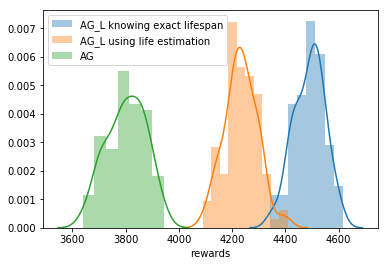

In [8]:
sns.distplot(plt_agl, label='AG_L knowing exact lifespan')
sns.distplot(plt_agl_est, label='AG_L using life estimation')
sns.distplot(plt_ag, label='AG')
plt.legend()
plt.xlabel('rewards')
pass

In [120]:
class UCB_L:
    def __init__(self, records, pool, unborn, est_life=False):
        self.startingTime = records.iloc[0].timestamp
        self.records = records.itertuples()
        self.rewards = 0
        self.alive = [] # heap: (death, id)
        self.pool = copy.deepcopy(pool) # ordered dict of arms
        self.unborn = copy.deepcopy(unborn)
        self.avg_life = 0
        self.X = 0
        self.est_life = est_life
        
    def update(self, record):
        self.rewards += record.clicked
        self.pool[record.id].rewards += record.clicked
        self.pool[record.id].T += 1
        self.pool[record.id].X = self.pool[record.id].rewards / self.pool[record.id].T
        n_seen = len(self.pool) - len(self.unborn)
        self.X = (self.X * (n_seen-1) + record.clicked) / n_seen
    
    def filter_live(self, t):  
        # pop born arms to alive
        while self.unborn and self.pool[self.unborn[-1]].birth<=self.time:
            arm = self.unborn.pop()
            self.pool[arm].s = t
            heapq.heappush(self.alive, (self.pool[arm].death, arm))
        # pop dead arms from alive
        while self.alive:
            death, arm = self.alive[0]
            if death < self.time:
                heapq.heappop(self.alive)
                
                dying = self.pool[arm]
                dying.l = t
                n_dead = len(self.pool) - len(self.unborn) - len(self.alive)
                self.avg_life = (self.avg_life* (n_dead-1) + (dying.l-dying.s+1)) / n_dead
                
            else:
                break
        return
                
    def initialize(self, m):
        self.m = m
        while self.t < m:
            record = next(self.records) # raise StopIteration
            self.time = record.timestamp
            self.filter_live(self.t)
            if not pool[record.id].T: # not played
                self.update(record)
                self.t += 1
    
    def play(self, n, c=.008):
        def score(heap_tuple):
            #r = self.t / (self.time - self.startingTime) # divider==0???
            arm = self.pool[heap_tuple[1]]
            if arm.T:
                T = arm.T
                X = arm.X
            else: # if it's never played, use estimation
                T = 1
                X = self.X
            if not c or not self.avg_life:
                return X + np.sqrt( 2*np.log(self.t - arm.s + 1)/T )
            else:
                if self.avg_life+arm.s-self.t+1 <= 0:
                    return X
                else:
                    return X + c*np.log(self.avg_life+arm.s-self.t+1) * np.sqrt(2*np.log(self.t - arm.s+1)/T) 
            '''if not self.est_life:    
                if c:
                    return X + c*np.log(r*(arm.death - self.time) + 1) * np.sqrt( 2*np.log(r*(self.time - arm.birth) + 1)/T)
                else:
                    return X + np.sqrt( 2*np.log(self.t - arm.s + 1)/T )
            else:
                if not self.avg_life:
                    return X + np.sqrt( 2*np.log(self.t - arm.s + 1)/T )
                try:
                    return X + c*np.log(self.avg_life+arm.s-self.t+1) * np.sqrt(2*np.log(self.t - arm.s+1)/T)
                except RuntimeWarning:
                    #print(self.avg_life, arm.s, t)
                    return X'''
                
        self.n = n
        for self.t in range(self.m, n):
            while True: # keep trying
                record = next(self.records) # raise StopIteration
                self.time = record.timestamp
                self.filter_live(self.t)
                pick = max(self.alive, key=score)[1]
                if pick == record.id:
                    self.update(record)
                    break

In [94]:
# test
ucbl = UCB_L(records, pool, unborn)
ucbl.initialize(25)
ucbl.play(1000,.008)
ucbl.rewards

41

In [64]:
ucbl = UCB_L(records, pool, unborn, est_life=True)
ucbl.initialize(25)

In [66]:
ucbl.play(1000,.008)
tmp = ucbl.rewards
tmp

24

In [80]:
ucbl.avg_life

687.3333333333334

In [87]:
# tune UCBL(using life estimation)
def player(i):
    print('player',i,'started')
    start = time.time()
    ucbl = UCB_L(records[:500000], pool, unborn, est_life=True)
    ucbl.initialize(25)
    ucbl.play(20000, c=i)
    end = time.time()
    print('player',i,'finished with',ucbl.rewards,'time spent:', end-start)
    return ucbl.rewards
with Pool(4) as p:
    ucb_tune = p.map(player, [1,.1,.01,.03,.001,.003,.008,.005,.05,.0001,.0005])

player 1 started
player 0.03 started
player 0.1 started
player 0.01 started
player 1 finished with 741 time spent: 61.7092649936676
player 0.001 started
player 0.1 finished with 738 time spent: 62.90302300453186
player 0.003 started
player 0.01 finished with 912 time spent: 63.005666732788086
player 0.008 started
player 0.03 finished with 847 time spent: 63.613940477371216
player 0.005 started
player 0.001 finished with 962 time spent: 57.071961879730225
player 0.05 started
player 0.008 finished with 930 time spent: 58.607370138168335
player 0.0001 started
player 0.003 finished with 941 time spent: 59.851927042007446
player 0.0005 started
player 0.005 finished with 937 time spent: 60.24378967285156
player 0.05 finished with 785 time spent: 58.947763204574585
player 0.0001 finished with 947 time spent: 58.26153039932251
player 0.0005 finished with 947 time spent: 58.174619913101196


In [112]:
# UCB
def player(i):
    print('player',i,'started')
    start = time.time()
    ucbl = UCB_L(records[i*10000:], pool, unborn)
    ucbl.initialize(25)
    ucbl.play(100000, None)
    end = time.time()
    print('player',i,'finished with',ucbl.rewards,'time spent:', end-start)
    return ucbl.rewards
plt_ucb = []
with Pool(4) as p:
    plt_ucb += p.map(player, [i for i in range(100)])

player 0 started
player 7 started
player 14 started
player 21 started
player 14 finished with 5078 time spent: 268.3995747566223
player 15 started
player 0 finished with 5027 time spent: 272.2576639652252
player 1 started
player 7 finished with 4986 time spent: 273.5036795139313
player 8 started
player 21 finished with 5069 time spent: 284.5913472175598
player 22 started
player 1 finished with 5000 time spent: 268.7509250640869
player 2 started
player 15 finished with 4992 time spent: 274.58513855934143
player 16 started
player 8 finished with 5043 time spent: 273.97358751296997
player 9 started
player 22 finished with 5040 time spent: 275.1592855453491
player 23 started
player 2 finished with 5008 time spent: 266.30498337745667
player 3 started
player 9 finished with 5033 time spent: 275.29362320899963
player 16 finished with 4954 time spent: 280.35651421546936
player 10 started
player 17 started
player 23 finished with 5084 time spent: 280.22068905830383
player 24 started
player 3 fi

In [23]:
with open('save/plt_ucb','wb') as f:
    pickle.dump(plt_ucb, f)

In [113]:
sum(plt_ucb)

517467

In [51]:
with open('save/plt_ucbl_est','wb') as f:
    pickle.dump(plt_ucbl_est, f)

In [121]:
# UCB_L using life estimation
def player(i):
    print('player',i,'started')
    start = time.time()
    ucbl = UCB_L(records[i*10000:], pool, unborn, est_life=True)
    ucbl.initialize(25)
    ucbl.play(100000, .001)
    end = time.time()
    print('player',i,'finished with',ucbl.rewards,'time spent:', end-start)
    return ucbl.rewards
with Pool(6) as p:
    plt_ucbl_est = p.map(player, [i for i in range(100)])

player 5 started
player 20 started
player 10 started
player 15 started
player 0 started
player 25 started
player 25 finished with 6182 time spent: 169.7355659008026
player 26 started
player 0 finished with 6199 time spent: 218.04218816757202
player 1 started
player 20 finished with 6045 time spent: 241.69905638694763
player 21 started
player 5 finished with 6129 time spent: 242.77078652381897
player 6 started
player 10 finished with 5741 time spent: 265.89113211631775
player 11 started
player 15 finished with 6009 time spent: 276.0275070667267
player 16 started
player 21 finished with 6233 time spent: 183.79301047325134
player 22 started
player 26 finished with 6170 time spent: 282.1767506599426
player 27 started
player 6 finished with 5180 time spent: 219.21483421325684
player 7 started
player 11 finished with 6299 time spent: 234.0858497619629
player 12 started
player 1 finished with 6204 time spent: 304.58904504776
player 2 started
player 16 finished with 5634 time spent: 262.562350

In [124]:
with open('save/plt_ucbl_est', 'wb') as f:
    pickle.dump(plt_ucbl_est,f)

In [122]:
sum(plt_ucbl_est)

634598

In [ ]:
# UCB_L
def player(i):
    print('player',i,'started')
    start = time.time()
    ucbl = UCB_L(records[i*10000:], pool, unborn)
    ucbl.initialize(25)
    ucbl.play(100000, .008)
    end = time.time()
    print('player',i,'finished with',ucbl.rewards,'time spent:', end-start)
    return ucbl.rewards
plt_ucbl = []
with Pool(4) as p:
    plt_ucbl += p.map(player, [i for i in range(100)])

In [108]:
with open('save/plt_ucbl', 'wb') as f:
    pickle.dump(plt_ucbl,f)

In [ ]:
with open('save/plt_ucbl', 'wb') as f:
    plt_ucbl=pickle.load(f)

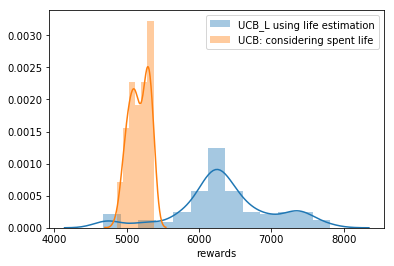

In [7]:
sns.distplot(plt_ucbl_est, label='UCB_L using life estimation')
sns.distplot(plt_ucb, label='UCB: considering spent life')
plt.legend()
plt.xlabel('rewards')
pass

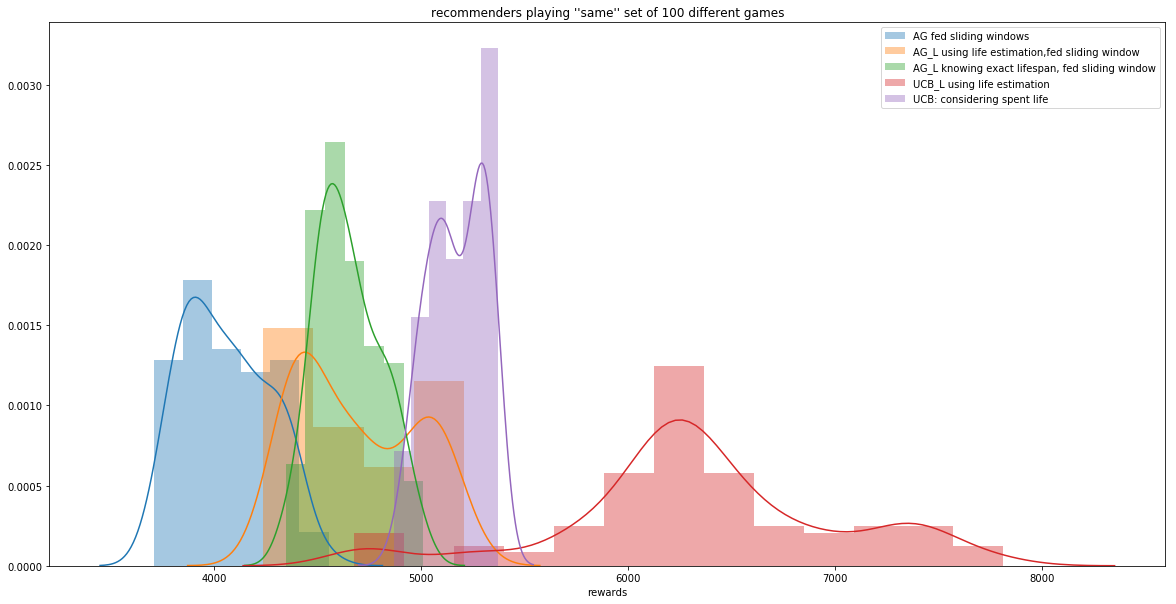

In [22]:
plt.figure(figsize=(20,10))
sns.distplot(plt_ag_sw, label='AG fed sliding windows')
sns.distplot(plt_agl_est_sw, label='AG_L using life estimation,fed sliding window')
sns.distplot(plt_agl_sw, label='AG_L knowing exact lifespan, fed sliding window')
sns.distplot(plt_ucbl_est, label='UCB_L using life estimation')
sns.distplot(plt_ucb, label='UCB: considering spent life')
plt.legend()
plt.title('''recommenders playing ''same'' set of 100 different games''')
plt.xlabel('rewards')